In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
model_reg=tf.keras.models.load_model('models/combined_model.h5')
model_cls=tf.keras.models.load_model('models/combined_model_cls.h5')

In [3]:
# "temperature", "dwpt", "wspd", "wdir", "prcp", "rhum", "pres","day_of_week", "hour_of_day", "season", "month","is_holiday", "is_weekend", "population","solar_generation"


def predict_for_date(
    date,
    temperature,
    solar_generation,
    hour_of_day,
    is_holiday,
    # dwpt,
    wspd,
    # wdir,
    prcp,
    rhum,
    # pres,
    day_of_week,
    season,
    # month,
    is_weekend,
    model_clf,
    model_reg,
    le,
    scaler,
):
    # Create a DataFrame for the input data
    new_data = pd.DataFrame(
        {
            "day_of_week": [day_of_week],
            "hour_of_day": [hour_of_day],
            "is_weekend": [is_weekend],
            "temperature": [temperature],
            "is_holiday": [is_holiday],
            # "dwpt": [dwpt],
            "wspd": [wspd],
            # "wdir": [wdir],
            "prcp": [prcp],
            "rhum": [rhum],
            # "pres": [pres],
            "season": [season],
            # "month": [month],
            "solar_generation": [solar_generation],
        }
    )

    cnn_features = ["temperature", "wspd", "prcp", "rhum"]
    lstm_features = ["day_of_week", "hour_of_day", "season"]
    ann_features = ["is_holiday", "is_weekend", "solar_generation"]

    # Scale the input data
    new_data_scaled = scaler.transform(new_data)

    X_cnn = np.array(new_data_scaled[:, : len(cnn_features)]).reshape(
        (1, len(cnn_features), 1)
    )
    X_lstm = np.array(
        new_data_scaled[:, len(cnn_features) : len(cnn_features) + len(lstm_features)]
    ).reshape((1, len(lstm_features), 1))
    X_ann = np.array(new_data_scaled[:, len(cnn_features) + len(lstm_features) :])

    # Make predictions using the classification model
    predicted_class_label = model_clf.predict([X_cnn, X_lstm, X_ann])
    predicted_compensation_method = le.inverse_transform(
        np.argmax(predicted_class_label, axis=1)
    )

    # Make predictions using the regression model
    predicted_peak_supply = model_reg.predict([X_cnn, X_lstm, X_ann])

    return {
        "date": date,
        "hour_of_day": hour_of_day,
        "compensation_method": predicted_compensation_method[0],
        "peak_supply_needed": predicted_peak_supply[0],
    }


def generate_24_hour_predictions(
    timestamp,
    temperature,
    solar_generation,
    is_holiday,
    # dwpt,
    wspd,
    # wdir,
    prcp,
    rhum,
    # pres,
    day_of_week,
    season,
    # month,
    is_weekend,
    model_clf,
    model_reg,
    le,
    scaler,
):

    results = []

    hour = timestamp.hour

    prediction = predict_for_date(
        timestamp,
        temperature,
        solar_generation,
        hour,
        is_holiday,
        # dwpt,
        wspd,
        # wdir,
        prcp,
        rhum,
        # pres,
        day_of_week,
        season,
        # month,
        is_weekend,
        model_clf,
        model_reg,
        le,
        scaler,
    )
    results.append(prediction)

    df_predictions = pd.DataFrame(results)

    return df_predictions

In [4]:
test_dataset=pd.read_csv('dataset/test_dataset_2024.csv')
test_dataset.head()

,timestamp,day_of_week,hour_of_day,is_weekend,temperature,is_holiday,solar_generation,dwpt,wspd,wdir,prcp,rhum,pres,season,month
0,2024-01-01 00:00:00,0,0,0,28.534249,0,0.786249,9.0,7.6,270.0,0.0,81.0,1019.4,3,1.0
1,2024-01-01 01:00:00,0,1,0,18.140664,0,7.331477,9.1,0.0,0.0,0.0,88.0,1019.0,3,1.0
2,2024-01-01 02:00:00,0,2,0,19.539847,0,9.877753,9.1,7.6,260.0,0.0,88.0,1020.0,3,1.0
3,2024-01-01 03:00:00,0,3,0,17.519129,0,1.215103,8.4,5.4,320.0,0.0,83.0,1021.2,3,1.0
4,2024-01-01 04:00:00,0,4,0,18.255590,0,2.476539,9.1,5.4,30.0,0.0,88.0,1021.0,3,1.0


In [5]:
test_dataset.dtypes

timestamp            object
day_of_week           int64
hour_of_day           int64
is_weekend            int64
temperature         float64
is_holiday            int64
solar_generation    float64
dwpt                float64
wspd                float64
wdir                float64
prcp                float64
rhum                float64
pres                float64
season                int64
month               float64
dtype: object

In [6]:
test_dataset['timestamp']=pd.to_datetime(test_dataset['timestamp'])

In [7]:
def generate_year_predictions(test_dataset, rf_clf, rf_reg, le,scaler):

    all_predictions = []

    for _, row in test_dataset.iterrows():
        timestamp = pd.to_datetime(row["timestamp"])
        temperature = row["temperature"]
        solar_generation = row["solar_generation"]
        is_holiday = row["is_holiday"]
        # dwpt = row["dwpt"]
        wspd = row["wspd"]
        # wdir = row["wdir"]
        prcp = row["prcp"]
        rhum = row["rhum"]
        # pres = row["pres"]
        day_of_week = row["day_of_week"]
        season = row["season"]
        # month = row["month"]
        is_weekend = row["is_weekend"]

        # Generate predictions for each hour of the day
        daily_predictions = generate_24_hour_predictions(
            timestamp,
            temperature,
            solar_generation,
            is_holiday,
            # dwpt,
            wspd,
            # wdir,
            prcp,
            rhum,
            # pres,
            day_of_week,
            season,
            # month,
            is_weekend,
            rf_clf,
            rf_reg,
            le,
            scaler
        )
        all_predictions.append(daily_predictions)

    # Combine all daily predictions into one DataFrame
    df_all_predictions = pd.concat(all_predictions, ignore_index=True)

    return df_all_predictions

In [8]:
import pickle

with open("models/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

In [9]:
with open("models/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

In [10]:
df_year_predictions = generate_year_predictions(
    test_dataset, model_cls, model_reg, le, scaler
)


ValueError: in user code:

    File "c:\Users\ariel\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\ariel\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ariel\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\ariel\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\ariel\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ariel\anaconda3\envs\py310\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "sequential_1" expects 1 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 4, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 3, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 3) dtype=float32>]


In [11]:
df_year_predictions.head()

,date,hour_of_day,compensation_method,peak_supply_needed
0,2024-01-01 00:00:00,0,Normal Operation,[18037.967]
1,2024-01-01 01:00:00,1,Normal Operation,[13892.584]
2,2024-01-01 02:00:00,2,Normal Operation,[17908.094]
3,2024-01-01 03:00:00,3,Normal Operation,[15751.621]
4,2024-01-01 04:00:00,4,Normal Operation,[15871.291]


In [12]:
df_year_predictions['peak_supply_needed'] = df_year_predictions['peak_supply_needed'].apply(lambda x: x[0])

In [13]:
df_year_predictions

,date,hour_of_day,compensation_method,peak_supply_needed
0,2024-01-01 00:00:00,0,Normal Operation,18037.966797
1,2024-01-01 01:00:00,1,Normal Operation,13892.583984
2,2024-01-01 02:00:00,2,Normal Operation,17908.093750
3,2024-01-01 03:00:00,3,Normal Operation,15751.621094
4,2024-01-01 04:00:00,4,Normal Operation,15871.291016
...,...,...,...,...
7403,2024-11-04 11:00:00,11,Increased Renewable Energy Integration,14310.191406
7404,2024-11-04 12:00:00,12,Normal Operation,14284.413086
7405,2024-11-04 13:00:00,13,Normal Operation,14767.035156
7406,2024-11-04 14:00:00,14,Normal Operation,14862.785156


In [14]:
df_year_predictions['compensation_method'].unique()

array(['Normal Operation', 'Increased Renewable Energy Integration',
       'Peak Load Shifting', 'Lower Power Supply'], dtype=object)

In [15]:
df_year_predictions.to_csv('dataset/predictions_2024-result-1.csv',index=False)

In [16]:
df_train=pd.read_csv("dataset/24-hours Delhi Power Consumption dataset.csv")

C:\Users\ariel\AppData\Local\Temp\ipykernel_18200\3307948204.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_train.head(100), x='hour_of_day', y='load', palette='Set1')


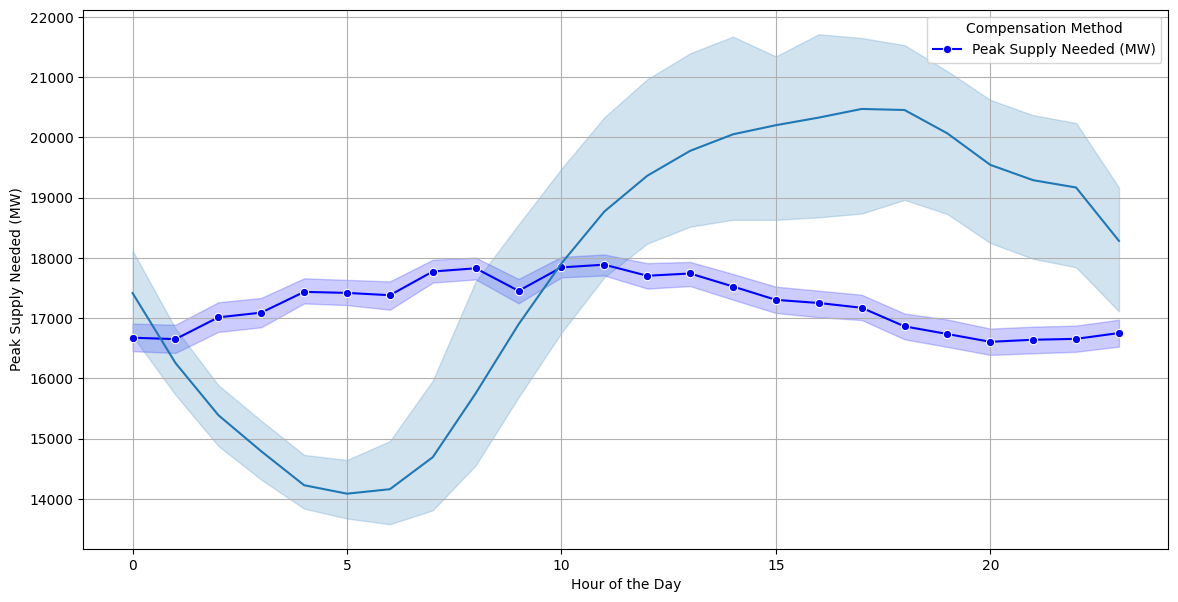

In [17]:
import seaborn as sns

def plot_predictions(df_predictions):
    plt.figure(figsize=(14, 7))

    sns.lineplot(data=df_predictions, x='hour_of_day', y='peak_supply_needed', marker='o', color='blue', label='Peak Supply Needed (MW)')
    
    sns.lineplot(data=df_train.head(100), x='hour_of_day', y='load', palette='Set1')

    # plt.title('Hourly Predictions for {}'.format(df_predictions['date'][0]))
    plt.xlabel('Hour of the Day')
    plt.ylabel('Peak Supply Needed (MW)')
    plt.legend(title='Compensation Method')
    plt.grid(True)
    plt.show()

plot_predictions(df_year_predictions)